Best Lambda: 10, Best R^2: 0.6858
Validation cost: 2.7801e+03
Mean Squared Error (MSE) on validation set: 5.4939e+03
Test cost: 2.5324e+04
Mean Squared Error (MSE) on test set: 5.0589e+04
R^2 on test set: -inf


/tmp/ipykernel_71649/4214017559.py:98: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared_test = 1 - (np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))


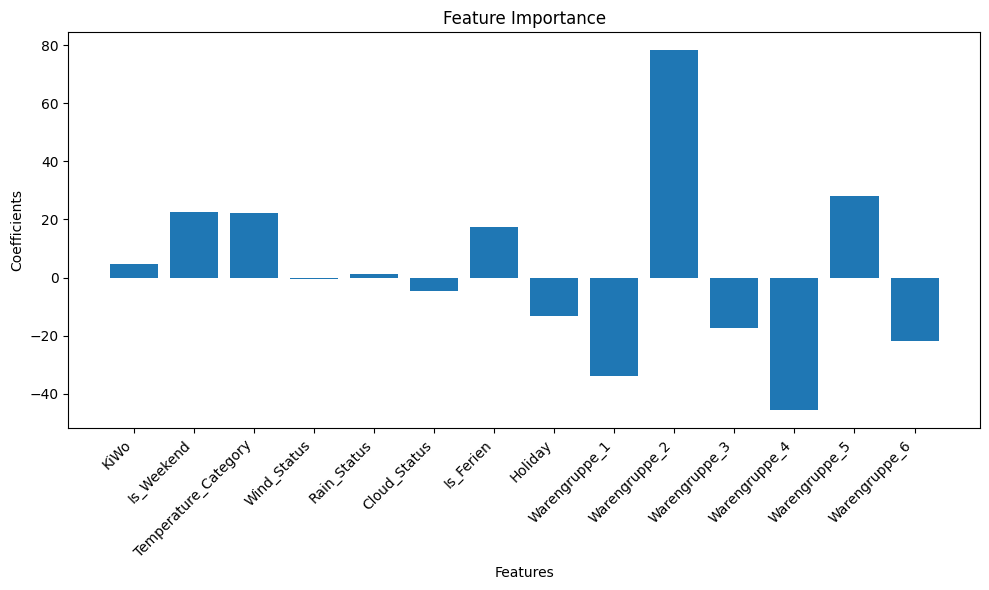


Final Model Parameters:
Feature: KiWo, Coefficient: 4.6339
Feature: Is_Weekend, Coefficient: 22.5973
Feature: Temperature_Category, Coefficient: 22.4035
Feature: Wind_Status, Coefficient: -0.5692
Feature: Rain_Status, Coefficient: 1.1384
Feature: Cloud_Status, Coefficient: -4.7797
Feature: Is_Ferien, Coefficient: 17.3692
Feature: Holiday, Coefficient: -13.0924
Feature: Warengruppe_1, Coefficient: -33.7755
Feature: Warengruppe_2, Coefficient: 78.2523
Feature: Warengruppe_3, Coefficient: -17.2109
Feature: Warengruppe_4, Coefficient: -45.7702
Feature: Warengruppe_5, Coefficient: 28.0270
Feature: Warengruppe_6, Coefficient: -21.9942
Intercept (b): 204.4238
Predicted sales for the test set have been saved to final_submission_linear_model.csv with predictions rounded to 2 decimal places.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the processed data and feature columns
wetter_umsatzdaten_kiwo = pd.read_csv("../0_DataPreparation/processed_data_imputed.csv")

with open("../0_DataPreparation/feature_columns.txt", "r") as f:
    feature_columns = f.read().splitlines()

# Split dataset into training, validation, and test sets
training_start_date = '2013-07-01'
training_end_date = '2017-07-31'
validation_start_date = '2017-08-01'
validation_end_date = '2018-07-31'
test_start_date = '2018-08-01'
test_end_date = '2019-07-30'

training_data = wetter_umsatzdaten_kiwo[
    (wetter_umsatzdaten_kiwo['Datum'] >= training_start_date) & 
    (wetter_umsatzdaten_kiwo['Datum'] <= training_end_date)
]
validation_data = wetter_umsatzdaten_kiwo[
    (wetter_umsatzdaten_kiwo['Datum'] >= validation_start_date) & 
    (wetter_umsatzdaten_kiwo['Datum'] <= validation_end_date)
]
test_data = wetter_umsatzdaten_kiwo[
    (wetter_umsatzdaten_kiwo['Datum'] >= test_start_date) & 
    (wetter_umsatzdaten_kiwo['Datum'] <= test_end_date)
]

X_train = training_data[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy(dtype=np.float64)
y_train = training_data['Umsatz'].to_numpy()

X_val = validation_data[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy(dtype=np.float64)
y_val = validation_data['Umsatz'].to_numpy()

X_test = test_data[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy(dtype=np.float64)
y_test = test_data['Umsatz'].to_numpy()

# Normalize features
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Train a regularized linear regression model
def compute_cost_reg(X, y, w, b, lambda_):
    m = X.shape[0]
    cost = (1 / (2 * m)) * np.sum((np.dot(X, w) + b - y) ** 2)
    reg_cost = (lambda_ / (2 * m)) * np.sum(w ** 2)
    return cost + reg_cost

def gradient_descent_reg(X, y, w_in, b_in, alpha, num_iters, lambda_):
    w = w_in
    b = b_in
    for _ in range(num_iters):
        dj_dw = (1 / len(X)) * np.dot((np.dot(X, w) + b - y), X) + (lambda_ / len(X)) * w
        dj_db = (1 / len(X)) * np.sum(np.dot(X, w) + b - y)
        w -= alpha * dj_dw
        b -= alpha * dj_db
    return w, b

# Hyperparameter tuning
lambda_values = [0.01, 0.1, 1, 10]
best_r_squared = -np.inf
best_lambda = None

for lambda_ in lambda_values:
    w_init = np.zeros(X_train.shape[1])
    b_init = 0
    w_final, b_final = gradient_descent_reg(X_train, y_train, w_init, b_init, 0.01, 1000, lambda_)
    y_val_pred = np.dot(X_val, w_final) + b_final
    r_squared = 1 - (np.sum((y_val - y_val_pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2))

    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_lambda = lambda_

print(f"Best Lambda: {best_lambda}, Best R^2: {best_r_squared:.4f}")

# Final model training with best lambda
w_final, b_final = gradient_descent_reg(X_train, y_train, np.zeros(X_train.shape[1]), 0, 0.01, 1000, best_lambda)

# Validate the model
y_val_pred = np.dot(X_val, w_final) + b_final
validation_cost = compute_cost_reg(X_val, y_val, w_final, b_final, best_lambda)
mse_val = np.mean((y_val - y_val_pred) ** 2)
print(f"Validation cost: {validation_cost:.4e}")
print(f"Mean Squared Error (MSE) on validation set: {mse_val:.4e}")

# Test the model
y_test_pred = np.dot(X_test, w_final) + b_final
test_cost = compute_cost_reg(X_test, y_test, w_final, b_final, best_lambda)
mse_test = np.mean((y_test - y_test_pred) ** 2)
r_squared_test = 1 - (np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f"Test cost: {test_cost:.4e}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.4e}")
print(f"R^2 on test set: {r_squared_test:.4f}")

# Feature importance visualization
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, w_final)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Output final model parameters
print("\nFinal Model Parameters:")
for i, feature in enumerate(feature_columns):
    print(f"Feature: {feature}, Coefficient: {w_final[i]:.4f}")
print(f"Intercept (b): {b_final:.4f}")

# Replace the 'Umsatz' column with predicted sales, rounded to 2 decimal places
test_data = test_data.copy()  # Ensure you're not modifying the original dataset
test_data['Umsatz'] = np.round(y_test_pred, 2)  # Overwrite 'Umsatz' with rounded predictions

# Select columns to export
export_columns = ['id', 'Umsatz']  # Only keep the updated columns
export_data = test_data[export_columns]

# Export to CSV
export_file_path = "final_submission_linear_model.csv"
export_data.to_csv(export_file_path, index=False)

print(f"Predicted sales for the test set have been saved to {export_file_path} with predictions rounded to 2 decimal places.")


